In [2]:
import pandas as pd
import numpy as np
import scipy
from influxdb import InfluxDBClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from dateutil import tz

sns.set(style="whitegrid")
sns.set(font_scale=0.7)

basestations = ['office', 'playroom', 'livingroom', 'kitchen', 'bedroomjk', 'bedroomcc', 'bedrooms']
beacon = 'iphonejd'
url = '192.168.50.134'
port = 8086
username = 'homeassistant'
password = 'homeassistant'
classification = 'jd_iphone_room_training_data'
# startdatetime = '2023-07-20T16:00:00'
startdatetime = '2023-07-27T16:00:00'

In [35]:
class InfluxDB:
    def __init__(self, url: str, port: int, username: str, password: str,
                 basestations: list, beacon: str, classification: str,
                 measurement: str = "distance", shuffle: bool = True,
                 startdatetime: str = None, enddatetime: str = None):
        self.client = InfluxDBClient(url, port, username, password)
        self.basestations = basestations
        self.beacon = beacon
        self.classification = classification
        self.measurement = measurement
        self.shuffle = shuffle
        self.timefilter = '1=1'
        self.timefilter += f"\n\t\tAND time >= '{InfluxDB.convert_to_rfc3339(startdatetime)}'" if startdatetime else ''
        self.timefilter += f"\n\t\tAND time <= '{InfluxDB.convert_to_rfc3339(enddatetime)}'" if enddatetime else ''

    @property
    def df_basestation_beacon_values(self):
        where = ''.join([f"\n\t\t    OR entity_id = 'mqtt_{self.beacon}_{basestation}_{self.measurement}'" for basestation in self.basestations])
        query = f'''
            SELECT entity_id as basestation, value as distance
            FROM homeassistant.autogen.m
            WHERE {self.timefilter}
                AND (
                    1<>1 {where}
                )
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    @property
    def df_classifications(self):
        query = f'''
            SELECT state as y
            FROM homeassistant.autogen.state
            WHERE {self.timefilter}
                AND entity_id = '{self.classification}'
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    @property
    def df_espresense_y(self):
        query = f'''
            SELECT state as y
            FROM homeassistant.autogen.state
            WHERE {self.timefilter}
                AND entity_id = 'espresense_iphonejd_room'
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    def get_Xy(self):
        self.df = (
            pd.concat([self.df_basestation_beacon_values, self.df_classifications], axis=0)
            .pivot(index=['time', 'y'], columns='basestation', values='distance')
            .fillna(method='ffill')
            .reset_index('y')
            .fillna(method='ffill')
            .drop(np.nan, axis=1)
            .dropna()
            .query('y != "None"')
        )
        if self.shuffle:
            self.df = self.df.sample(frac=1)
        self.X = self.df.drop('y', axis=1)
        self.y = self.df.y
        self.y = self.y.apply(lambda x: 'Outdoors' if x in ['Driveway', 'Garden'] else x)
        return self.X, self.y

    def show_basestation_strength(self):
        fig, ax = plt.subplots(3, figsize=(10, 3), sharex=True, sharey=True)
        data = self.df_basestation_beacon_values
        for i, basestation in enumerate(data.basestation.unique()):
            sns.lineplot(
                data=data.loc[data.basestation == basestation],
                x='time', y='distance',
                linewidth=0.5, ax=ax[i]
            ).set_title(basestation)
        plt.show()

    @staticmethod
    def convert_to_rfc3339(date_string):
        dt = parse(date_string)
        dt = dt.astimezone(tz.UTC)
        return dt.strftime('%Y-%m-%dT%H:%M:%SZ')

<Axes: ylabel='y'>

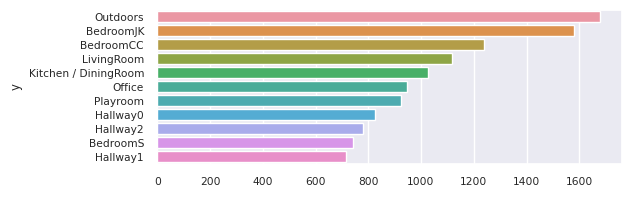

In [36]:
influx = InfluxDB(
    url=url,
    port=port,
    username=username,
    password=password,
    basestations=basestations,
    beacon=beacon,
    classification=classification,
    startdatetime=startdatetime,
)

X, y = influx.get_Xy()

plt.figure(figsize=(6, 2))
sns.barplot(x=y.value_counts().values, y=y.value_counts().index)

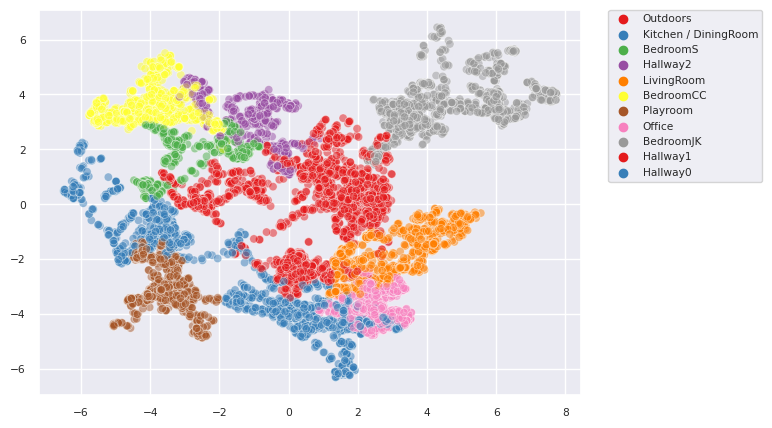

In [37]:
pca = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=y, palette='Set1', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

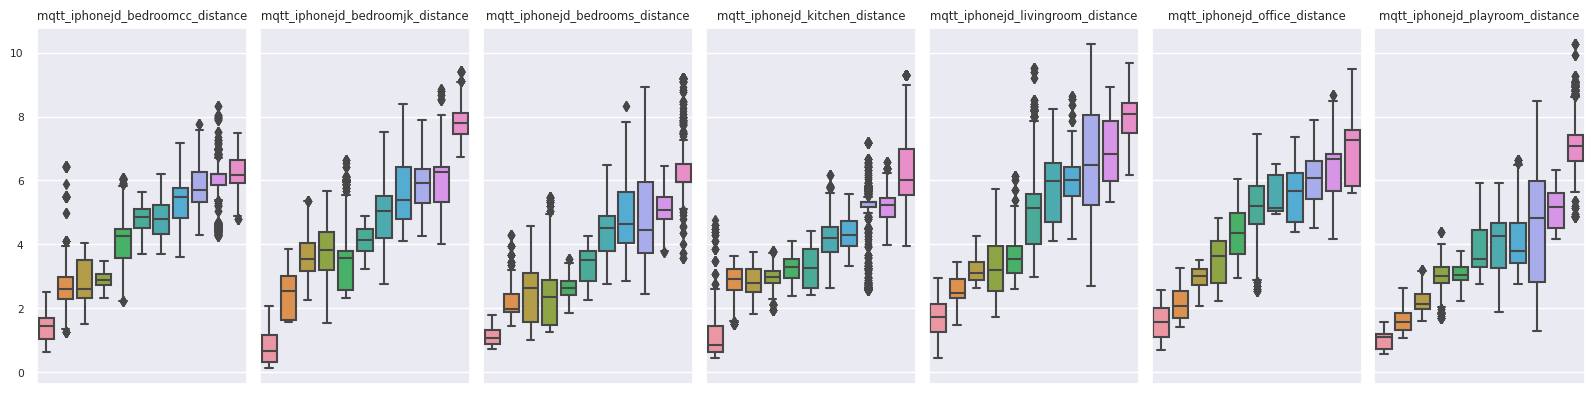

In [38]:
fig, ax = plt.subplots(ncols=len(X.columns), figsize=(16, 4), sharey=True)
for i, basestation in enumerate(X.columns):
    sns.boxplot(
        data=X.join(y), x='y', y=basestation,
        order=X.join(y).groupby('y').mean()[basestation].sort_values().index,
        ax=ax[i]
    ).set_title(basestation)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels('')
plt.tight_layout()
plt.show()

In [39]:
# Disabled grid search using random distribution of min/max values

if False:

    X, y = influx.get_Xy()

    n = 25
    stats = X.describe()

    x_min = stats.loc['min'].values.reshape(-1, 1)
    x_max = stats.loc['max'].values.reshape(-1, 1)
    x_25 = stats.loc['25%'].values.reshape(-1, 1)
    x_75 = stats.loc['50%'].values.reshape(-1, 1)

    # get min search grid
    mu = np.mean([x_min, x_25])
    sigma = (x_25 - x_min) / 4
    rand = np.random.normal(mu, sigma, (len(basestations), n)).round(1)
    lim_min_search = pd.DataFrame(rand, index=X.columns)

    # get max search grid
    mu = np.mean([x_75, x_max])
    sigma = (x_max - x_75) / 4
    rand = np.random.normal(mu, sigma, (len(basestations), n)).round(1)
    lim_max_search = pd.DataFrame(rand, index=X.columns)

    # plot grid distribution
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.boxplot(X, orient='h', whis=[0, 100])
    sns.stripplot(pd.DataFrame(lim_min_search, index=X.columns).T, orient='h', marker='o', size=4)
    sns.stripplot(pd.DataFrame(lim_max_search, index=X.columns).T, orient='h', marker='X', size=4)
    ax.set_xlim(X.min().min()-1, X.max().max()+1)
    plt.show()




    results = []

    for i in range(n):
        
        X, y = influx.get_Xy()
        
        # remove outliers
        X[X < lim_min_search.iloc[:, i]] = lim_min_search.iloc[:, i].to_list()
        X[X > lim_max_search.iloc[:, i]] = lim_max_search.iloc[:, i].to_list()
        
        # Normalise
        scaler = X.describe().loc[['mean', 'std']].round(2).T
        X = (X - scaler['mean']) / scaler['std']
        
        # Define model
        lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=0.1, solver='lbfgs', multi_class='multinomial')
        
        # Cross-validation
        scores = cross_val_score(lr, X, y, cv=StratifiedKFold(n_splits=3))
        results.append(scores.mean())
        print(f"{i}:\t{scores.mean().round(2)} {scores.std().round(2)} {scores.round(2)}")

In [40]:
results = []

for min in np.arange(0.1, 0.8, 0.1):
    for max in np.arange(0.2, 1.1, 0.1):
        min = min.round(1)
        max = max.round(1)
    
        X, y = influx.get_Xy()

        # remove outliers
        lim_min = X.join(y).groupby('y').quantile(min).min().round(2)
        lim_max = X.quantile(max).round(2)
        X[X < lim_min] = lim_min.to_list()
        X[X > lim_max] = lim_max.to_list()

        # Normalise
        scaler = X.describe().loc[['mean', 'std']].round(2).T
        X = (X - scaler['mean']) / scaler['std']

        # Define model
        lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=0.1, solver='lbfgs', multi_class='multinomial')

        # Cross-validation
        scores = cross_val_score(lr, X, y, cv=StratifiedKFold(n_splits=3))
        results.append({'min': min, 'max': max, 'score': scores.mean(), 'std': scores.std()})
        print(f"{min.round(1)=} | {max.round(1)=}:\t{scores.mean().round(2)} {scores.std().round(2)} {scores.round(2)}")

min.round(1)=0.1 | max.round(1)=0.2:	0.9 0.0 [0.9  0.9  0.91]
min.round(1)=0.1 | max.round(1)=0.3:	0.95 0.0 [0.95 0.95 0.95]
min.round(1)=0.1 | max.round(1)=0.4:	0.96 0.0 [0.96 0.96 0.96]
min.round(1)=0.1 | max.round(1)=0.5:	0.97 0.0 [0.96 0.97 0.96]
min.round(1)=0.1 | max.round(1)=0.6:	0.98 0.0 [0.98 0.97 0.98]
min.round(1)=0.1 | max.round(1)=0.7:	0.98 0.0 [0.98 0.97 0.97]
min.round(1)=0.1 | max.round(1)=0.8:	0.97 0.0 [0.97 0.97 0.97]
min.round(1)=0.1 | max.round(1)=0.9:	0.97 0.0 [0.97 0.98 0.97]
min.round(1)=0.1 | max.round(1)=1.0:	0.97 0.0 [0.97 0.97 0.97]
min.round(1)=0.2 | max.round(1)=0.2:	0.9 0.01 [0.91 0.91 0.9 ]
min.round(1)=0.2 | max.round(1)=0.3:	0.95 0.0 [0.95 0.95 0.95]
min.round(1)=0.2 | max.round(1)=0.4:	0.96 0.0 [0.95 0.96 0.96]
min.round(1)=0.2 | max.round(1)=0.5:	0.97 0.0 [0.97 0.96 0.97]
min.round(1)=0.2 | max.round(1)=0.6:	0.98 0.0 [0.98 0.98 0.98]
min.round(1)=0.2 | max.round(1)=0.7:	0.98 0.0 [0.98 0.98 0.97]
min.round(1)=0.2 | max.round(1)=0.8:	0.97 0.0 [0.97 0.97

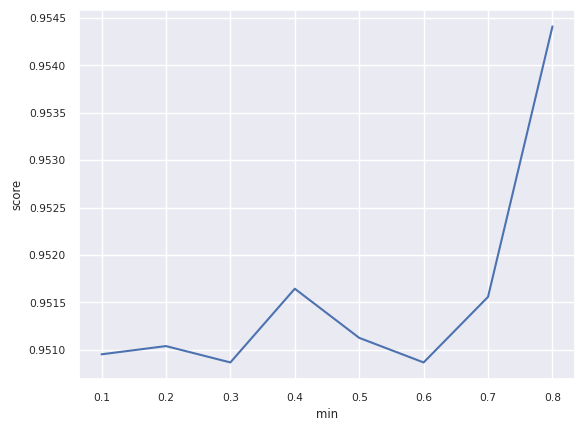

In [32]:
scores_df = pd.DataFrame(results)
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))
sns.lineplot(data=scores_df, x='min', y='score', ax=ax[0]).set_title('min')
sns.lineplot(data=scores_df, x='max', y='score', ax=ax[0]).set_title('max')
plt.tisght_layout(pad=5)
plt.show()

Cross-val scores:	0.95 0.01 [0.95 0.95 0.94]
Train-test train score:	0.95
Train-test test score:	0.95
                      precision    recall  f1-score   support

           BedroomCC       0.95      1.00      0.97       620
           BedroomJK       1.00      1.00      1.00       790
            BedroomS       0.98      0.92      0.95       372
            Driveway       0.83      0.90      0.86       461
              Garden       0.87      0.76      0.81       378
            Hallway0       0.90      0.97      0.93       414
            Hallway1       0.97      0.92      0.94       357
            Hallway2       0.92      0.93      0.93       389
Kitchen / DiningRoom       1.00      0.92      0.96       514
          LivingRoom       0.94      0.95      0.95       560
              Office       0.97      1.00      0.98       473
            Playroom       0.99      1.00      1.00       463

            accuracy                           0.95      5791
           macro avg       0

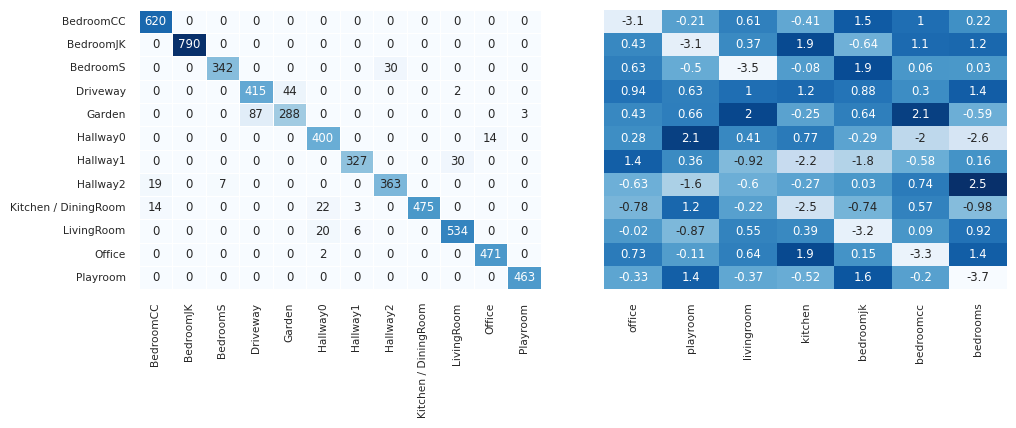

In [33]:
X, y = influx.get_Xy()

# remove outliers
if True:
    lim_min = X.join(y).groupby('y').quantile(.5).min().round(2)
    lim_max = X.quantile(.75).round(2)
    X[X < lim_min] = lim_min.to_list()
    X[X > lim_max] = lim_max.to_list()

# Add polynomial features
#X_2 = (X ** 2).rename(columns=lambda col: f"{col}^{2}" if col in X.columns else col)
#X = pd.concat([X, X_2], axis=1)
#X = PolynomialFeatures(2, include_bias=True).fit_transform(X)

# Normalise
scaler = X.describe().loc[['mean', 'std']].round(2).T
X = (X - scaler['mean']) / scaler['std']

# Define model
lr = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', C=0.1, solver='lbfgs', multi_class='multinomial')

# Cross-validation
scores = cross_val_score(lr, X, y, cv=StratifiedKFold(n_splits=3))
print(f"Cross-val scores:\t{scores.mean().round(2)} {scores.std().round(2)} {scores.round(2)}")

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.5)
lr.fit(X_train, y_train)
print(f'Train-test train score:\t{lr.score(X_train, y_train).round(2)}')
print(f'Train-test test score:\t{lr.score(X_test, y_test).round(2)}')
y_pred = lr.predict(X_test)

# Train Test Metrics
print(classification_report(y_test, y_pred))
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plt.tight_layout(pad=4)
sns.heatmap(
    data=confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cbar=False, square=False,
    linecolor='white', linewidths=0.5, cmap='Blues',
    xticklabels=lr.classes_,
    yticklabels=lr.classes_,
    ax=ax[0],
)
sns.heatmap(
    data=lr.coef_.round(2),
    annot=True,
    cbar=False,
    cmap='Blues',
    xticklabels=basestations,
    yticklabels=lr.classes_,
    ax=ax[1],
)
plt.show()

# Final model fit
lr.fit(X, y);

In [ ]:
def write_yaml(coef, intercept, classes, feature_names, device, measurement='distance'):
    class_names = ", ".join([('\n' + 10*' ' if i % 6 == 0 else '') + f'"{c}"' for i, c in enumerate(lr.classes_)])
    x_variables = f"\n{8 * ' '}".join([
        f"{{% set x{i+1} = (max(min(states('sensor.{f.replace('distance', measurement)}')"
        f" | float({lim_max.loc[f]}), {lim_max.loc[f]}), {lim_min.loc[f]})"
        f" - {scaler.loc[f, 'mean']}) / {scaler.loc[f, 'std']} %}}"
        for i, f in enumerate(feature_names)
    ])
    logits = ', '.join(
        [f"\n{10*' '}{intercept[i].round(6)} " + ' '.join(
        [f"+ x{j+1}*{coef[i, j].round(6)}"
         for j in range(coef.shape[1])])
         for i in range(len(classes))]
    )
    return f"""
    - name: "ESPresense-ML {device} Prediction Class"
      unique_id: espresense-ml_{device.lower()}_predictionclass
      state: >
        {{% set classes = [{class_names}\n{8*' '}] %}}
        {x_variables}
        {{% set logits = [{logits}\n{8*' '}] %}}
        {{{{classes[logits.index(logits | max)]}}}}
    """

print(write_yaml(lr.coef_, lr.intercept_, lr.classes_, lr.feature_names_in_, beacon))


    - name: "ESPresense-ML iphonejd Prediction Class"
      unique_id: espresense-ml_iphonejd_predictionclass
      state: >
        {% set classes = [
          "BedroomCC", "BedroomJK", "BedroomS", "Driveway", "Garden", "Hallway0", 
          "Hallway1", "Hallway2", "Kitchen / DiningRoom", "LivingRoom", "Office", "Playroom"
        ] %}
        {% set x1 = (max(min(states('sensor.mqtt_iphonejd_bedroomcc_distance') | float(5.72), 5.72), 1.44) - 4.15) / 1.49 %}
        {% set x2 = (max(min(states('sensor.mqtt_iphonejd_bedroomjk_distance') | float(5.99), 5.99), 0.76) - 4.14) / 1.71 %}
        {% set x3 = (max(min(states('sensor.mqtt_iphonejd_bedrooms_distance') | float(5.21), 5.21), 1.07) - 3.6) / 1.37 %}
        {% set x4 = (max(min(states('sensor.mqtt_iphonejd_kitchen_distance') | float(5.18), 5.18), 0.83) - 3.7) / 1.3 %}
        {% set x5 = (max(min(states('sensor.mqtt_iphonejd_livingroom_distance') | float(6.69), 6.69), 1.75) - 4.65) / 1.72 %}
        {% set x6 = (max(min(states('s

In [ ]:
import paho.mqtt.client as mqtt
import json

if False:
    verbose = False

    X_live = {
        'espresense/devices/jd_iphone/bedroomjk': 0.,
        'espresense/devices/jd_iphone/livingroom': 0.,
        'espresense/devices/jd_iphone/office': 0.,
    }

    def on_connect(client, userdata, flags, rc):
        print("Connected with result code "+str(rc))
        client.subscribe("espresense/devices/jd_iphone/bedroomjk")
        client.subscribe("espresense/devices/jd_iphone/office")
        client.subscribe("espresense/devices/jd_iphone/livingroom")

    def on_message(client, userdata, msg):
        data = json.loads(msg.payload)
        if 'raw' in data:
            X_live[msg.topic] = data['raw']
            X = pd.DataFrame(
                X_live.values(),
                index=['MQTT iPhoneJD BedroomJK Raw', 'MQTT iPhoneJD LivingRoom Raw', 'MQTT iPhoneJD Office Raw']
            ).T
            pred = lr.predict_proba(X)[0]
            pred_class, prob = lr.classes_[pred.argmax()], pred.max()
            print(f"Class: {pred_class}, Probability: {prob}")

    client = mqtt.Client()
    client.username_pw_set("mqtt-user", "vlmSDF543")
    client.on_connect = on_connect
    client.on_message = on_message
    client.connect("192.168.50.134", 1883, 60)
    client.loop_forever()